# Привычки студента против Академической успеваемости

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import statsmodels.api as sm
import plotly.express as px
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, levene, shapiro

In [90]:
df = pd.read_csv("student_habits_performance.csv")
df

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,S1995,21,Female,2.6,0.5,1.6,No,77.0,7.5,Fair,2,High School,Good,6,Yes,76.1
996,S1996,17,Female,2.9,1.0,2.4,Yes,86.0,6.8,Poor,1,High School,Average,6,Yes,65.9
997,S1997,20,Male,3.0,2.6,1.3,No,61.9,6.5,Good,5,Bachelor,Good,9,Yes,64.4
998,S1998,24,Male,5.4,4.1,1.1,Yes,100.0,7.6,Fair,0,Bachelor,Average,1,No,69.7


## Общая картина студента

In [91]:
df_group_genders = df.groupby('gender').size().reset_index().rename(columns={0: 'Количество'})
print(df_group_genders)
fig1 = px.bar(df_group_genders, x = 'gender', y = 'Количество', labels='Количество', text_auto = True)
fig1.update_layout(title={'text': 'Распределение студентов по полу', 'x': 0.5},
                    xaxis_title = 'Пол студента')

   gender  Количество
0  Female         481
1    Male         477
2   Other          42


In [92]:
df_group_ages = df.groupby('age').size().reset_index().rename(columns={0: 'Количество'})
fig1 = px.bar(df_group_ages, x = 'age', y = 'Количество', labels='Количество', text_auto = True)
fig1.update_layout(title={'text': 'Распределение студентов по возрастам', 'x': 0.5},
                    xaxis_title = 'Возраст студента')

In [94]:
df_group_work = df.groupby(['part_time_job', 'gender']).size().reset_index().rename(columns={0: 'Количество'})
fig4 = px.bar(df_group_work, x = 'part_time_job', color = 'gender', y = 'Количество', labels='Количество', text_auto = True)
fig4.update_layout(title={'text': 'Распределение студентов по занятости (работает или нет)', 'x': 0.5},
                    xaxis_title = 'Есть ли у студента работа',
                    legend = {'title': 'Пол студента'})

In [ ]:

fig5 = px.histogram(
    df, 
    x='exam_score',
    facet_col='gender',
    color='gender',   
    opacity=0.7,   
    barmode='overlay',  
    facet_col_spacing=0.05, 
)

fig5.update_layout(
    title={
        'text': 'Распределение оценок за экзамен по полу',
        'x': 0.5,
    },
    legend = {'title': 'Пол студента'},
    yaxis_title='Количество студентов',
    showlegend=True,  
    plot_bgcolor='white', 
    bargap=0.1,
)


fig5.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig5.update_xaxes(matches=None, showgrid=True)
fig5.update_yaxes(matches=None, showgrid=True)


fig5.show()

In [96]:

fig6 = px.histogram(
    df, 
    x='sleep_hours',
    facet_col='gender',
    color='gender',   
    opacity=0.7,   
    barmode='overlay',  
    facet_col_spacing=0.05, 
)

fig6.update_layout(
    title={
        'text': 'Распределение количества часов сна в день по полу',
        'x': 0.5,
    },
    legend = {'title': 'Пол студента'},
    yaxis_title='Количество студентов',
    showlegend=True,  
    plot_bgcolor='white', 
    bargap=0.1,
)


fig6.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig6.update_xaxes(matches=None, showgrid=True)
fig6.update_yaxes(matches=None, showgrid=True)


fig6.show()

## Гипотеза 1 -- уровень успеваемости у работающих/неработающих студентов отличается (двусторонний тест)

### Статистический анализ (основная часть)

#### (a) Вычисление точечных оценок

Сделаем равное разбиение по стратам (работающие/неработающие студенты) на выборку из 30 человек

In [97]:
n = 30

working_students = df[df['part_time_job'] == 'Yes']
non_working_students = df[df['part_time_job'] == 'No']


sample_working = working_students.sample(int(n/2), random_state=42)
sample_non_working = non_working_students.sample(int(n / 2), random_state=42)


sample = pd.concat([sample_working, sample_non_working])

sample

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
945,S1945,23,Male,6.0,2.9,2.1,Yes,98.9,6.4,Poor,0,NaN,Average,7,No,100.0
989,S1989,24,Male,1.0,1.4,2.1,Yes,76.4,4.9,Fair,3,High School,Average,6,No,47.6
690,S1690,18,Male,2.5,1.8,1.2,Yes,88.3,6.9,Fair,1,High School,Average,6,No,70.5
869,S1869,22,Male,2.8,2.5,2.7,Yes,86.4,6.3,Fair,4,Master,Average,10,No,74.6
63,S1063,17,Male,4.1,2.3,2.6,Yes,76.5,5.1,Fair,3,Bachelor,Average,9,No,77.6
541,S1541,18,Female,4.2,3.8,3.4,Yes,84.8,5.4,Good,2,High School,Good,5,No,67.4
840,S1840,23,Male,2.5,0.2,0.9,Yes,89.5,7.5,Good,3,High School,Good,6,Yes,80.0
371,S1371,24,Male,0.8,1.4,3.8,Yes,76.5,7.5,Good,2,Bachelor,Average,10,No,36.0
958,S1958,18,Male,0.0,3.8,1.3,Yes,89.5,5.7,Good,5,High School,Average,5,No,31.1
703,S1703,24,Male,0.9,3.3,1.6,Yes,87.3,6.5,Poor,6,Bachelor,Good,5,No,37.9




| **Статистика**               | **Формула**                                                                                                                                 |
|-------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------|
| **Среднее арифметическое**    | $$\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i$$                                                                                               |
| **Дисперсия**                 | $$s^2 = \frac{1}{n-1} \sum_{i=1}^{n} (x_i - \bar{x})^2$$                                                                                  |
| **Стандартное отклонение**    | $$s = \sqrt{s^2}$$                                                                                                                         |
| **Медиана**                   | $$\text{Медиана} = \begin{cases} x_{\frac{n+1}{2}}, & \text {если }n \text{ нечётное} \\ \frac{x_{\frac{n}{2}} + x_{\frac{n}{2}+1}}{2}, & \text{если } n \text{ чётное} \end{cases}$$ |
| **Мода**                      | $$\text{Мода} = \text{самое часто вречающееся значение}$$                                                                                        |
| **Минимум**                   | $$\min(x)$$                                                                                                                                |
| **Максимум**                  | $$\max(x)$$                                                                                                                                |
| **Доля работающих студентов** | $$\text{Доля} = \left( \frac{\text{Число работающих}}{n} \right) \times 100\%$$                                                            |


In [98]:
sample_mean = sample['exam_score'].mean()

sample_var = sample['exam_score'].var(ddof=1)

sample_std = sample['exam_score'].std(ddof = 1)

sample_median = sample['exam_score'].median()

sample_mode = sample['exam_score'].mode()

sample_min = sample['exam_score'].min()

sample_max = sample['exam_score'].max()


sample_working_students = (len(sample[
    sample['part_time_job'] == 'Yes']) / n) * 100


print(f"""
Результаты анализа:

1. Описательные статистики баллов за экзамен:
   - Среднее арифметическое: {sample_mean:.2f}
   - Дисперсия: {sample_var:.2f}
   - Стандартное отклонение: {sample_std:.2f}
   - Медиана: {sample_median:.2f}
   - Мода: {sample_mode.values[0]} (встречается {sample_mode.value_counts().iloc[0]} раз)
   - Минимум: {sample_min}
   - Максимум: {sample_max}
""")


Результаты анализа:

1. Описательные статистики баллов за экзамен:
   - Среднее арифметическое: 63.83
   - Дисперсия: 423.06
   - Стандартное отклонение: 20.57
   - Медиана: 63.45
   - Мода: 100.0 (встречается 1 раз)
   - Минимум: 18.4
   - Максимум: 100.0



**Метод максимального правдоподобия (ММП)**

**ММП** — это  метод, позволяющий найти оценки параметров распределения, при которых наблюдаемые данные становятся наиболее вероятными

Если предположить, что данные имеют вид нормального распределения $ \mathcal{N}(\mu, \sigma^2) $, то:

1. **Оценка среднего**:
   $$
   \hat{\mu}_{\text{ММП}} = \frac{1}{n} \sum_{i=1}^{n} x_i = \bar{x}
   $$

2. **Оценка дисперсии**:
   $$
   \hat{\sigma}^2_{\text{ММП}} = \frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^2
   $$



**Свойства ММП-оценок**
- **Смещённость**: Оценка дисперсии $\hat{\sigma}^2_{\text{ММП}}$ **смещённая**, но **состоятельная** (при $n \to \infty $) смещение стремится к 0
- **Эффективность**: Для нормального распределения ММП-оценки являются **эффективными** (имеют минимальную дисперсию среди всех несмещённых оценок).

**Вывод**:  
ММП-оценки для нормального распределения совпадают с выборочным средним и смещённой дисперсией. Они оптимальны при выполнении предположения о нормальности данных

In [99]:
mle_mean = sample_mean  # Совпадает с выборочным средним
mle_var = sample_var * (n - 1) / n  # Поправка на смещённость
print(f"ММП-оценка среднего: {mle_mean:.2f}")
print(f"ММП-оценка дисперсии: {mle_var:.2f}")

ММП-оценка среднего: 63.83
ММП-оценка дисперсии: 408.96


**Неравенство Рао-Крамера** задаёт **минимально возможную дисперсию** для любой **несмещённой оценки** параметра.

Оно позволяет проверить, является ли оценка **эффективной** (т.е. имеет ли она наименьшую дисперсию среди всех несмещённых оценок)


Для параметра **среднего** $(\mu)$ нормального распределения $(\mathcal{N} (\mu, \sigma^2))$:
1. **Информация Фишера** для $(\mu)$:
   $$
   I(\mu) = \frac{n}{\sigma^2},
   $$
   где:
   - $n$ — размер выборки,
   - $\sigma^2$ — истинная дисперсия.

2. **Нижняя граница Рао-Крамера** для дисперсии оценки $(\hat{\mu})$:
   $$
   \text{Var}(\hat{\mu}) \geq \frac{1}{I(\mu)} = \frac{\sigma^2}{n}.
   $$



**Интерпретация**
- Если **дисперсия оценки** $(\hat{\mu})$ равна $(\frac{\sigma^2}{n})$, то оценка **эффективна**.
- Для нормального распределения **ММП-оценка** $(\hat{\mu} = \bar{x})$:
  - Несмещённая $(E[\bar{x}] = \mu)$,
  - Имеет дисперсию $(\text{Var}(\bar{x}) = \frac{\sigma^2}{n})$,
  - **Достигает** границы Рао-Крамера → оценка эффективна.


**Зачем это нужно?**
1. **Проверка оптимальности оценки**: Если оценка достигает границы, она наилучшая в классе несмещённых оценок.
2. **Сравнение методов**: Оценки с дисперсией, близкой к границе, предпочтительнее.


In [100]:
rao_cramer_lower_bound = mle_var / n
print(f"Нижняя граница Рао-Крамера для дисперсии среднего: {rao_cramer_lower_bound:.4f}")
print(f"Достигается ли граница? {rao_cramer_lower_bound == mle_var / n}") # Если true, значит, оценка эффективна

Нижняя граница Рао-Крамера для дисперсии среднего: 13.6319
Достигается ли граница? True


#### (b) Построение доверительных интервалов

Будем строить 95% ДИ для среднего балла за экзамен по тесту Стьюдента
$$
\bar{x} \pm t_{\alpha/2, \, n-1} \cdot \frac{s}{\sqrt{n}},
$$
где:
- $\bar{x}$ — выборочное среднее,
- $t_{\alpha/2, \, n-1}$ — критическое значение t-распределения,
- $s$ — выборочное стандартное отклонение,
- $n$ — размер выборки.

**Условия применения t-критерия:**
1. **Неизвестная дисперсия** генеральной совокупности.
2. **Нормальность данных** (для малых выборок, $n < 30$).  
   Для проверки нормальности можно использовать тест Шапиро-Уилка
3. Для больших выборок ($n \ge 30$) t-распределение приближается к нормальному (ЦПТ)


In [116]:
alpha = 0.05
t_stat = sts.t.ppf(1 - alpha / 2, df = n - 1)


ci_lower_mean = sample_mean - t_stat * sample_std / np.sqrt(n)
print('Нижняя граница ДИ:', ci_lower_mean)
ci_upper_mean = sample_mean + t_stat * sample_mean / np.sqrt(n)
print('Верхняя граница ДИ: ', ci_upper_mean)

Нижняя граница ДИ: 56.1496301737341
Верхняя граница ДИ:  87.66451370926953


Построение 95% доверительного интервала для дисперсии баллов за экзамен (χ²-распределение)

$$
\left[ \frac{(n-1)s^2}{\chi^2_{\alpha/2, \, n-1}}, \quad \frac{(n-1)s^2}{\chi^2_{1-\alpha/2, \, n-1}} \right],
$$
где:
- $ n$ — размер выборки,
- $s^2$ — выборочная дисперсия,
- $\chi^2_{\alpha/2, \, n-1}$ и $\chi^2_{1-\alpha/2, \, n-1}$ — критические значения χ²-распределения.


In [117]:
alpha = 0.05
xi_stat_lower = sts.chi2.ppf(1 - alpha / 2, df = n - 1)
print(xi_stat_lower)
xi_stat_upper = sts.chi2.ppf(alpha / 2, df = n - 1)
print(xi_stat_upper)

ci_lower_var = (n - 1) * sample_var / xi_stat_lower
print('Нижняя граница ДИ:', ci_lower_var)

ci_higher_var = (n - 1) * sample_var / xi_stat_upper
print('Верхняя граница ДИ: ', ci_higher_var)

45.72228580417452
16.04707169536489
Нижняя граница ДИ: 268.33135710988114
Верхняя граница ДИ:  764.545907995398


#### (c) Проверка статистических гипотез

Проверим, отличается ли средний балл у работающих и неработающих студентов на уровне значимости 0.05, используя двусторонний t-тест 
$$
H_0: \mu_{\text{балл за экзамен у работающих студентов}} = \mu_{\text{балл за экзамен у неработающих студентов}}
$$
$$
H_1: \mu_{\text{балл за экзамен у работающих студентов}} {=}\mathllap{/} \mu_{\text{балл за экзамен у неработающих студентов}}
$$

Формулы для t-теста:

**Объединённая дисперсия** (если дисперсии равны):  
   $$ s_p^2 = \frac{(n_1 - 1)s_1^2 + (n_2 - 1)s_2^2}{n_1 + n_2 - 2} $$  
   где:  
   - $( n_1, n_2 )$ — размеры выборок,  
   - $( s_1^2, s_2^2 )$ — выборочные дисперсии

1. **t-статистика**:  
   $$ t = \frac{\bar{x}_1 - \bar{x}_2}{s_p \cdot \sqrt{\frac{1}{n_1} + \frac{1}{n_2}}} $$  

2. **Степени свободы**:  
   $$ df = n_1 + n_2 - 2 $$  

---

**Если дисперсии неравны (тест Уэлча):**
1. **t-статистика**:  
   $$ t = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}} $$  

2. **Степени свободы** (формула Уэлча-Саттертуэйта):  
   $$ df = \frac{\left( \frac{s_1^2}{n_1} + \frac{s_2^2}{n_2} \right)^2}{\frac{(s_1^2/n_1)^2}{n_1 - 1} + \frac{(s_2^2/n_2)^2}{n_2 - 1}} $$  


In [103]:
working_students = sample[sample['part_time_job'] == 'Yes']['exam_score']
not_working_students = sample[sample['part_time_job'] == 'No']['exam_score']


t_stat, p_value = sts.ttest_ind(working_students, not_working_students, 
                                alternative='two-sided')

print(f"t-статистика: {t_stat:.3f}")
print(f"p-value: {p_value:.4f}")

t-статистика: 0.657
p-value: 0.5168


Т.к p-value > 0.05, то есть нет достаточных оснований отвергнуть нулевую гипотезу на уроане значимости 0.05

То есть, **нет статистически значимых различий в средних баллах между работающими и неработающими студентами**

### Визуализация и интерпретация

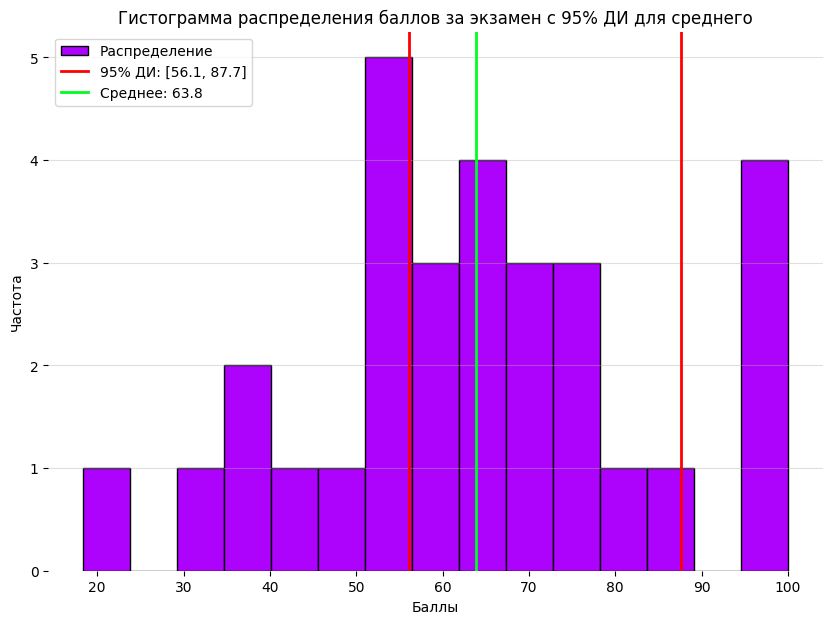

In [104]:
plt.figure(figsize=(10, 7))
plt.hist(sample['exam_score'], bins = 15, edgecolor = 'black', label='Распределение', color = '#ad03fc')
plt.axvline(ci_lower_mean, color = 'red', label=f'95% ДИ: [{ci_lower_mean:.1f}, {ci_upper_mean:.1f}]', linewidth = 2)
plt.axvline(ci_upper_mean, color = 'red', linewidth = 2)
plt.axvline(sample_mean, label=f'Среднее: {sample_mean:.1f}', color = '#03fc20', linewidth = 2)
plt.title('Гистограмма распределения баллов за экзамен с 95% ДИ для среднего')
plt.xlabel('Баллы')
plt.ylabel('Частота')
plt.legend()
plt.grid(axis='y', alpha = 0.4)
plt.box(False)
plt.show()

C:\Users\Smart\AppData\Local\Temp\ipykernel_11516\884248977.py:7: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



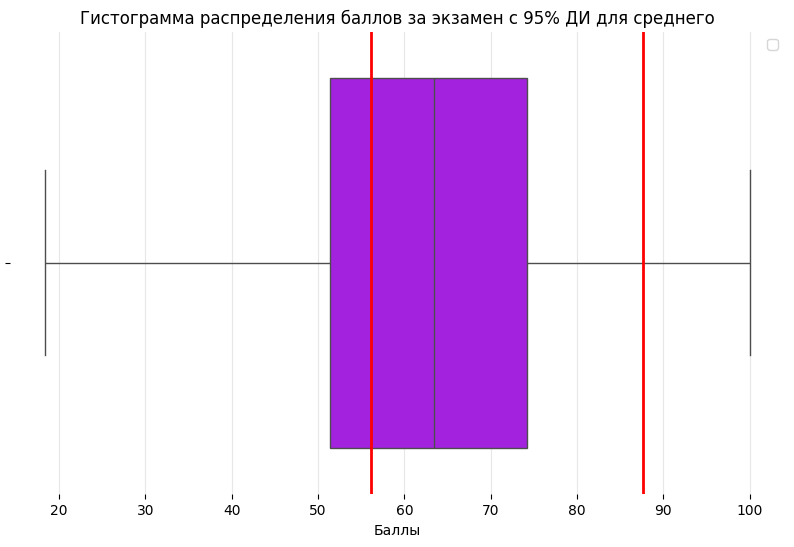

In [105]:
plt.figure(figsize=(10, 6))
sns.boxplot(sample['exam_score'], color = '#ad03fc', orient='h')
plt.axvline(ci_lower_mean, color = 'red', linewidth = 2)
plt.axvline(ci_upper_mean, color = 'red', linewidth = 2)
plt.title('Гистограмма распределения баллов за экзамен с 95% ДИ для среднего')
plt.xlabel('Баллы')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.box(False)
plt.show()

Среднее выборочное значение лежит в 95% ДИ, значит, у нас нет достаточных доказательств отвернуть H0

## Гипотеза 2 -- уровень успеваемости не зависит от количества часов сна

#### (a) Вычисление точечных оценок

In [ ]:
sleep_hours = df['sleep_hours']

mean_sleep = sleep_hours.mean()
var_sleep = sleep_hours.var(ddof=1)
std_sleep = sleep_hours.std(ddof=1)
median_sleep = sleep_hours.median()
mode_sleep = sleep_hours.mode().values[0]
min_sleep = sleep_hours.min()
max_sleep = sleep_hours.max()

print(f"""
Среднее количество часов сна: {mean_sleep:.1f} ч.
Дисперсия: {var_sleep:.1f}
Стандартное отклонение: {std_sleep:.1f} ч.
Медиана: {median_sleep} ч.
Мода: {mode_sleep} ч.
Минимум: {min_sleep} ч.
Максимум: {max_sleep} ч.
""")


Среднее количество часов сна: 6.5 ч.
Дисперсия: 1.5
Стандартное отклонение: 1.2 ч.
Медиана: 6.5 ч.
Мода: 6.5 ч.
Минимум: 3.2 ч.
Максимум: 10.0 ч.



Предположим, что данные имеют нормальное распределение:
ММП-оценки для нормального распределения совпадают с выборочными средним и дисперсией:

In [107]:
mle_mean_sleep = mean_sleep
mle_var_sleep = sleep_hours.var(ddof=0)  # смещённая дисперсия (для ММП)
print(f"ММП-оценки: μ = {mle_mean_sleep:.1f}, σ² = {mle_var_sleep:.1f}")

ММП-оценки: μ = 6.5, σ² = 1.5


Проверка по методу Рао-Крамера

In [108]:
rao_cramer_bound = mle_var_sleep / n
print(f"Нижняя граница Рао-Крамера: {rao_cramer_bound:.4f}")
print(f"Достигается ли граница? {rao_cramer_bound == mle_var_sleep / n}")

Нижняя граница Рао-Крамера: 0.0501
Достигается ли граница? True


#### (b) Построение доверительных интервалов

Будем строить 95% ДИ для среднего количества часов сна по тесту Стьюдента

In [ ]:
alpha = 0.05
t_crit = sts.t.ppf(1 - alpha/2, df=n-1)
ci_mean_lower = mean_sleep - t_crit * (std_sleep / (n ** 0.5))
ci_mean_upper = mean_sleep + t_crit * (std_sleep / (n ** 0.5))
print(f"95% ДИ для среднего: [{ci_mean_lower:.1f}, {ci_mean_upper:.1f}]")

95% ДИ для среднего: [6.0, 6.9]


Будем строить 95% ДИ для дисперсии часов сна по тесту Хи-квадрат

In [110]:
chi2_lower = sts.chi2.ppf(1 - alpha/2, df=n-1)
chi2_upper = sts.chi2.ppf(alpha/2, df=n-1)
ci_var_lower = (n-1) * var_sleep / chi2_lower
ci_var_upper = (n-1) * var_sleep / chi2_upper
print(f"95% ДИ для дисперсии: [{ci_var_lower:.1f}, {ci_var_upper:.1f}]")

95% ДИ для дисперсии: [1.0, 2.7]


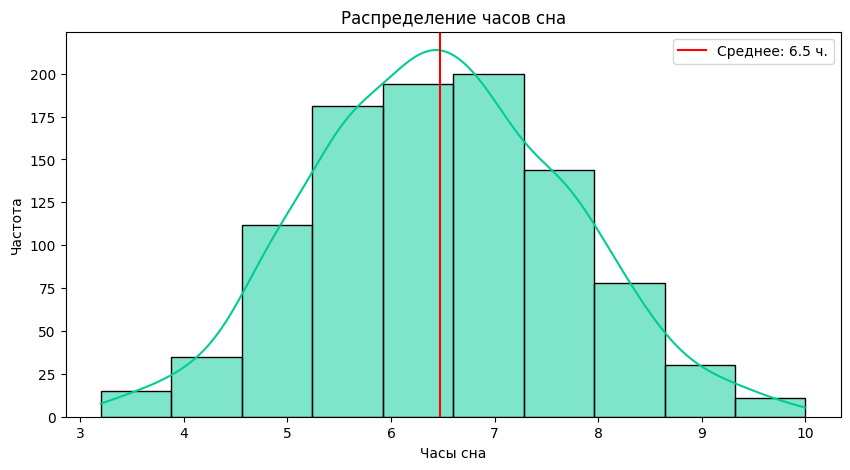

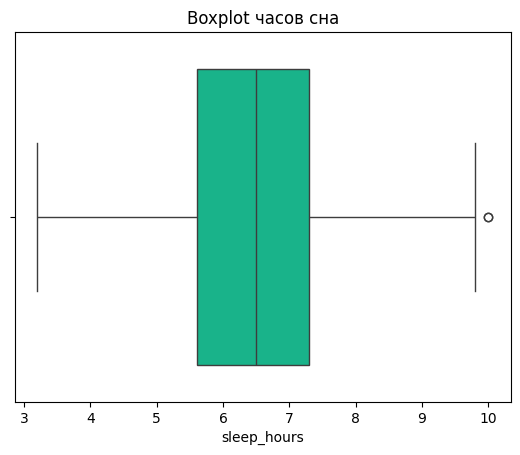

In [111]:
# Гистограмма с ядерной оценкой плотности
plt.figure(figsize=(10, 5))
sns.histplot(sleep_hours, kde=True, bins=10, color='#00cc96')
plt.axvline(mean_sleep, color='red', label=f'Среднее: {mean_sleep:.1f} ч.')
plt.title('Распределение часов сна')
plt.xlabel('Часы сна')
plt.ylabel('Частота')
plt.legend()
plt.show()

# Boxplot
sns.boxplot(x=sleep_hours, color='#00cc96')
plt.title('Boxplot часов сна')
plt.show()

#### (c) Проверка статистических гипотез

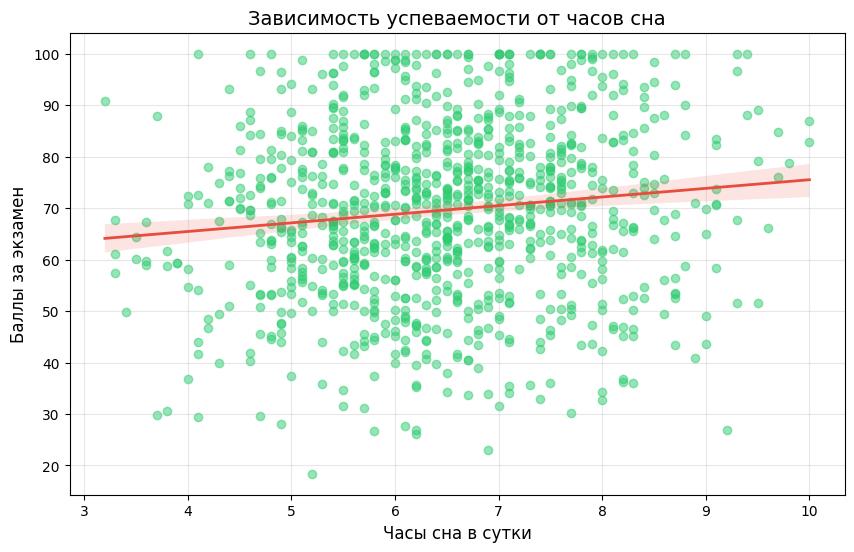

In [112]:
plt.figure(figsize=(10, 6))
sns.regplot(
    x='sleep_hours', 
    y='exam_score', 
    data=df, 
    scatter_kws={'alpha': 0.5, 'color': '#2ecc71'},
    line_kws={'color': '#e74c3c', 'linewidth': 2}
)
plt.title('Зависимость успеваемости от часов сна', fontsize=14)
plt.xlabel('Часы сна в сутки', fontsize=12)
plt.ylabel('Баллы за экзамен', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

Проверим, есть ли связь между количеством часов сна и баллом за экзамен на уровне значимости 0.05, используя корреляционный анализ (Спирмен или Пирсона) 

$H_0$: Корреляция между часами сна и успеваемостью равна нулю ($p = 0$)

$H_1$: Корреляция статистически значимо отличается от нуля ($p {=}\mathllap{/} 0$)


Проверка нормальности данных, чтобы понять используемый вид корреляции (либо Пирсона либо Спирмена), будем использовать тест на нормальность распределения Шапиро-Уилка

**1. Тест Шапиро-Уилка на нормальность**

Проверяет гипотезу о нормальности распределения данных.  

**Нулевая гипотеза** $H_0$: данные распределены нормально.  
**Статистика теста** $W$:  

$$
W = \frac{\left( \sum_{i=1}^n a_i x_{(i)} \right)^2}{\sum_{i=1}^n (x_i - \bar{x})^2},
$$  
где:  
- $ x_{(i)}$ — упорядоченные значения выборки,  
- $a_i$ — константы из таблиц Шапиро-Уилка,  
- $ \bar{x}$ — выборочное среднее  

**Решение**:  
Если $( p\text{-value} < \alpha )$ (например, $\alpha = 0.05$, то $H_0 $ отвергается)


In [113]:
_, p_sleep = shapiro(df['sleep_hours'])
_, p_score = shapiro(df['exam_score'])

print(f"p-value (нормальность часов сна): {p_sleep:.4f}")
print(f"p-value (нормальность баллов): {p_score:.4f}")

p-value (нормальность часов сна): 0.0888
p-value (нормальность баллов): 0.0000


Т.к p-value у баллов меньше 0.05, то у нас есть достаточно оснований предпологать, что вид распределения баллов у нас не нормальный, поэтому для обеих переменных мы будем использовать ранговую корреляцию Спирмена

**2. Корреляция Спирмена (ранговая корреляция)**

Используется, если данные не нормальны

**Формула коэффициента Спирмена**:  
$$
\rho = 1 - \frac{6 \sum_{i=1}^n d_i^2}{n(n^2 - 1)},
$$  
где:  
- $( d_i = \text{ранг}(x_i) - \text{ранг}(y_i) )$,  
- $( n )$ — количество наблюдений.  

**Проверка гипотезы**:  
- $( H_0: \rho = 0 $) (нет корреляции),  
- $( H_1: \rho \neq 0 $).  

**t-статистика**:  
$$
t = \frac{\rho \sqrt{n - 2}}{\sqrt{1 - \rho^2}},
$$  
которая имеет $t$-распределение с $( df = n - 2 )$



In [114]:
# Для Спирмена:
r, p_value = spearmanr(df['sleep_hours'], df['exam_score'])

print(f"Коэффициент корреляции: {r:.3f}")
print(f"p-value: {p_value:.4f}")

Коэффициент корреляции: 0.123
p-value: 0.0001


Так как у нас p-value < 0.05, то у нас **есть достаточно оснований отвергнуть нулевую гипотезу, а это значит, что все таки взаимосвязь между часами сна и успеваемостью есть**

Связь между ними, правда, слабая, если судить по коэф. корреляции (>0.1)